P => Piecewise Linear Contrast Stretching

GHE => Global Histogram Equalization

CLAHE => Contrast Limited Adaptive Histogram Equalization

# Function label and jpg and png

In [1]:
import os
import glob
import keras
import sklearn
import cv2 as cv2
import numpy as np
import pandas as pd
import PIL as Image
import seaborn as sns
import pathlib as path
import tensorflow as tf
import matplotlib as mpl
from datetime import datetime
import matplotlib.image as img
from keras import backend as k
from keras.models import Model
import matplotlib.pyplot as plt
from keras.utils import np_utils 
#from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.datasets import fashion_mnist
from keras.layers.convolutional import  MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import models, layers, optimizers, callbacks
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, ReLU,Flatten,Activation, GlobalAveragePooling2D, Input
%matplotlib inline

In [2]:
# %load _utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras import backend as K

# Test
def print_hello():
    print('Hello')

# define a function to plot the result from training step
def show_result(history): 
    temph = history.history
    temp_loss = temph['loss']
    temp_acc = temph['acc']
    temp_vloss = temph['val_acc']
    temp_vacc = temph['val_acc']

    max_valacc = max(temp_vacc)
    max_index = temp_vacc.index(max_valacc)
    max_index
    # Print the result from the last epoch
    print('Highest validation accuracy in Epoch: %s'%str(max_index+1))
    print('Train accuracy: %s'%temp_acc[max_index])
    print('Validation accuracy: %s'%temp_vacc[max_index])
    print('--------------------------------------------------')
    print('Last train Epoch')
    print('Train accuracy: %s'%history.history['acc'][-1])
    print('Validation accuracy: %s'%history.history['val_acc'][-1])

    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    epochs = range(1, len(loss) + 1)   
    
    # Define a subplot 
    fig, axs = plt.subplots(1,2,figsize=(15,4))
    
    # Plot loss
    loss_plot = axs[0]
    
    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()
    
    # Plot accuracy
    acc_plot = axs[1]
    
    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):
    
    # Calculate result
    result = model.evaluate(features,verbose=True)
    
    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)
    #labels = labels.argmax(axis=1)
    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))
    
    return pred_class


# Show a subplot of the incorrect predict data
def show_false_prediction(predict, feature, label, img_size=28, channel=1):

    false_pred = feature[(predict != label).tolist()]
    actual_label = label[(predict != label).tolist()]
    false_label = predict[(predict != label).tolist()]
    if channel == 3:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size,channel)
    elif channel == 1:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size)
    else:
        raise ValueError('Must be RGB or gray scale image')
    
    print(false_pred.shape)

    fig, ax = plt.subplots(3,10,figsize=(15,6))
    fig.suptitle('The incorrect prediction')

    for i in range(3):
        for j in range(10):
            ax[i,j].imshow(false_pred[j + i*10],cmap='gray')
            ax[i,j].set_title('Pred %s Act %s'%(false_label[j + i*10],actual_label[j + i*10]))
            
# Show activation value of each layer
def show_layer_activation(activation, model,num_layer,num_row=16):
    layer_names = []
    for layer in model.layers[:num_layer]:
        layer_names.append(layer.name)

    images_per_row = num_row
    for layer_name, layer_activation in zip(layer_names,activation):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features//images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col*images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0,255).astype('uint8')
                display_grid[col*size:(col +1)*size,
                             row*size:(row+1)*size] = channel_image
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],
                           scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
        
def deprocess_image(img):
    
    # Zero-centering and make sure that std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1
    
    # Clips to [0,1]
    img += 0.5
    img = np.clip(img,0,1)
    
    # Convert to RGB array
    img *= 255
    img = np.clip(img,0,255).astype('uint8')
    
    return img

def generate_pattern(model, layer_name , filter_index, size=150):
    # Build the loss function that maximize the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    
    # Compute the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]
    
    # Normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)
    
    # Return the loss and gradient given the input picture
    iterate = K.function([model.input],[loss, grads])
    
    # Stars from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    # Run gradient ascent for 40 step
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

### feed layer name. ie, 'conv_1'
def visualize_filter(model,layer_name, size= 64, margin = 5):

    # Empty black image to store results
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    # iterate over the row of result grid
    for i in range(8):
        # Iterate over the column of the result grid
        for j in range(8):
            # Generates the pattern for filter i + (j*8) in layer_name
            filter_img = generate_pattern(model, layer_name, i + (j*8), size=size)
            
            # Puts the result in the square (i,j) of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end,
                    vertical_start:vertical_end, :] = filter_img

    plt.figure(figsize=(20,20))
    plt.imshow(results)

In [3]:
from tqdm.notebook import tqdm
import os, fnmatch
from keras import backend as K
from pathlib import Path
# change sub directory in list
def dirToList(dir_path):
  
  #get path create list
  pth = os.listdir(path=dir_path)
  lst_dir = []

  for s in pth:
    temp = str(dir_path + '\\' + s + '\\')
    lst_dir.append(temp)
  
  #remove .csv
  for i in tqdm(range(len(lst_dir))):
    if lst_dir[i-1][len(lst_dir[i-1])-4:] == 'csv/':
      lst_dir.pop(i-1)
    if lst_dir[i-1][len(lst_dir[i-1])-4:] == 'md/':
      lst_dir.pop(i-1)

  return lst_dir
# map path to name
def mapName(lab_list, lab_dict):
  temp = []
  for i in tqdm(range(len(lab_list))):
    key_label = lab_dict[lab_list[i]]
    temp.append(key_label)
  return temp

## Data label check jpg and png

#### original

In [4]:
origi_train_ce = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\original\\train_cell\\Cemento')
origi_train_fi = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\original\\train_cell\\Fibrous')
origi_train_os = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\original\\train_cell\\Ossifying')
origi_test_ce = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\original\\test_cell\\Cemento')
origi_test_fi = os.listdir('C:\\Users\\CPE\Desktop\\senior2023\\original\\test_cell\\Fibrous')
origi_test_os = os.listdir('C:\\Users\\CPE\Desktop\\senior2023\\original\\test_cell\\Ossifying')

In [5]:
len(origi_test_ce)

15

#### gray

In [6]:
gray_train_ce = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\gray\\train_cell\\ce')
gray_train_fi = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\gray\\train_cell\\fi')
gray_train_os = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\gray\\train_cell\\os')
gray_test_ce = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\gray\\test_cell\\ce')
gray_test_fi = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\gray\\test_cell\\ce')
gray_test_os = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\gray\\test_cell\\ce')

#### ghe

In [7]:
ghe_train_ce = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\GHE\\train_cell\\ce')
ghe_train_fi = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\GHE\\train_cell\\fi')
ghe_train_os = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\GHE\\train_cell\\os')
ghe_test_ce = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\GHE\\test_cell\\ce')
ghe_test_fi = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\GHE\\test_cell\\fi')
ghe_test_os = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\GHE\\test_cell\\os')

#### clahe

In [8]:
clahe_train_ce = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\CLAHE\\train_cell\\ce')
clahe_train_fi = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\CLAHE\\train_cell\\fi')
clahe_train_os = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\CLAHE\\train_cell\\os')
clahe_test_ce = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\CLAHE\\test_cell\\ce')
clahe_test_fi = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\CLAHE\\test_cell\\fi')
clahe_test_os = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\CLAHE\\test_cell\\os')

#### gray+p+ghe

In [9]:
gray_p_ghe_train_ce = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\gray_P_GHE\\train_cell\\ce')
gray_p_ghe_train_fi = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\gray_P_GHE\\train_cell\\fi')
gray_p_ghe_train_os = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\gray_P_GHE\\train_cell\\os')
gray_p_ghe_test_ce = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\gray_P_GHE\\test_cell\\ce')
gray_p_ghe_test_fi = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\gray_P_GHE\\test_cell\\fi')
gray_p_ghe_test_os = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\gray_P_GHE\\test_cell\\os')

#### gray+p+clahe

In [10]:
gray_p_clahe_train_ce = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\gray + P + CLAHE\\train_cell\\ce')
gray_p_clahe_train_fi = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\gray + P + CLAHE\\train_cell\\fi')
gray_p_clahe_train_os = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\gray + P + CLAHE\\train_cell\\os')
gray_p_clahe_test_ce = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\gray + P + CLAHE\\test_cell\\ce')
gray_p_clahe_test_fi = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\gray + P + CLAHE\\test_cell\\fi')
gray_p_clahe_test_os = os.listdir('C:\\Users\\CPE\\Desktop\\senior2023\\gray + P + CLAHE\\test_cell\\os')

#### sum

In [11]:
all_dataset_train_gray = list(gray_train_ce) + list(gray_train_fi) +list(gray_train_os)
all_dataset_test_gray = list(gray_test_ce) + list(gray_test_fi) +list(gray_test_os)
all_gray = list(all_dataset_train_gray) + list(all_dataset_test_gray)

In [12]:
all_dataset_train_ghe = list(ghe_train_ce) + list(ghe_train_fi) +list(ghe_train_os)
all_dataset_test_ghe = list(ghe_test_ce) + list(ghe_test_fi) +list(ghe_test_os)
all_ghe = list(all_dataset_train_ghe) + list(all_dataset_test_ghe)

In [13]:
all_dataset_train_clahe = list(clahe_train_ce) + list(clahe_train_fi) +list(clahe_train_os)
all_dataset_test_clahe = list(clahe_test_ce) + list(clahe_test_fi) +list(clahe_test_os)
all_clahe = list(all_dataset_train_clahe) + list(all_dataset_test_clahe)

In [14]:
all_dataset = all_gray + all_ghe + all_clahe

In [15]:
ce_not = [x for x in all_dataset if not x.endswith('.png')]
print(ce_not)

[]


#### label

In [16]:
header_list = ["Type", "Description"]
md = pd.read_csv('C:\\Users\\CPE\\Desktop\\senior2023\\fco metdata.csv', names=header_list)
md

,Type,Description
0,ce,Cemento
1,os,Ossifying
2,fi,Fibrous


In [17]:
label_dict = dict(zip(md['Type'], md['Description']))
label_dict

{'ce': 'Cemento', 'os': 'Ossifying', 'fi': 'Fibrous'}

# Gray Image

#### Import model

##### model inceptionresnetv2

In [18]:
from tensorflow.keras.applications import InceptionResNetV2
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

In [19]:
def def_model():
    model = InceptionResNetV2(
    include_top=False, 
    input_shape=(224, 224, 3)
      )
    for layer in model.layers:
        layer.trainable = False
    flat1 = Flatten()(model.layers[-1].output)
  #full_conn = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(3, activation='sigmoid')(flat1)
	# define new model
    model = Model(inputs=model.inputs, outputs=output)
	# compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    model.save('/content/model/InceptionResNetV21.h5')
    model.summary()
    return model

##### model xception

In [20]:
#load pre trained Xception model
model_xcep1 = keras.applications.Xception(weights='imagenet',include_top=True, input_shape=(299,299,3),classifier_activation=None)

In [21]:
for layer in model_xcep1.layers:
    layer.trainable = False
x = Flatten() (model_xcep1.output)
prediction1 = Dense(3, activation = 'softmax')(x)
xcep1_model = Model(inputs = model_xcep1.input, outputs = prediction1)
xcep1_model.compile (loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['acc'])

##### model efficentnetb2

In [22]:
from keras.applications.efficientnet import EfficientNetB2

In [23]:
model_effi = tf.keras.applications.efficientnet.EfficientNetB2(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=(260,260,3),
    classifier_activation='softmax'
)
for layer in model_effi.layers:
    layer.trainable = False
x = Flatten() (model_effi.output)
prediction1 = Dense(3, activation = 'softmax')(x)
effi1_model = Model(inputs = model_effi.input, outputs = prediction1)
effi1_model.compile (loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['acc'])

### Train gray

In [24]:
sub_dir_train_gray = dirToList('C:\\Users\\CPE\\Desktop\\senior2023\\gray\\train_cell')
sub_dir_train_gray

  0%|          | 0/3 [00:00<?, ?it/s]

['C:\\Users\\CPE\\Desktop\\senior2023\\gray\\train_cell\\ce\\',
 'C:\\Users\\CPE\\Desktop\\senior2023\\gray\\train_cell\\fi\\',
 'C:\\Users\\CPE\\Desktop\\senior2023\\gray\\train_cell\\os\\']

In [25]:
sub_dir_train_Path = Path('C:\\Users\\CPE\\Desktop\\senior2023\\gray\\train_cell')
all_filepaths_train_gray = list(sub_dir_train_Path.glob(r'**\\*.png'))
all_filepaths_train_gray

[WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/train_cell/ce/ce_001_a.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/train_cell/ce/ce_002_a.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/train_cell/ce/ce_003_a.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/train_cell/ce/ce_004_a.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/train_cell/ce/ce_005_a.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/train_cell/ce/ce_006_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/train_cell/ce/ce_007_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/train_cell/ce/ce_008_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/train_cell/ce/ce_009_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/train_cell/ce/ce_010_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/train_cell/ce/ce_011_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/train_cell/ce/ce_012_b.png'),
 WindowsPath('C:/Users/CPE/D

In [26]:
all_path = []
all_index = []
for i in tqdm(range(len(sub_dir_train_gray))):
  temp = fnmatch.filter(os.listdir(sub_dir_train_gray[i]), "*.png")
  all_path.append(temp)
all_path_con =[item for sublist in all_path for item in sublist]
for i in tqdm(range(len(all_path_con))):
  index = all_path_con[i][:2]
  all_index.append(index)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

In [27]:
all_path_map_train_gray = mapName(all_index, label_dict)
all_path_map_train_gray[:10]

  0%|          | 0/449 [00:00<?, ?it/s]

['Cemento',
 'Cemento',
 'Cemento',
 'Cemento',
 'Cemento',
 'Cemento',
 'Cemento',
 'Cemento',
 'Cemento',
 'Cemento']

In [28]:
all_filepaths_df = pd.Series(all_filepaths_train_gray , name = 'filepath').astype(str)
all_path_map_df = pd.Series(all_path_map_train_gray, name = 'label')

all_df = pd.concat([all_filepaths_df, all_path_map_df], axis = 1)
all_df.shape

(449, 2)

In [29]:
all_df.head()

,filepath,label
0,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Cemento
1,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Cemento
2,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Cemento
3,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Cemento
4,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Cemento


### Test gray

In [30]:
sub_dir_test_gray = dirToList('C:\\Users\\CPE\\Desktop\\senior2023\\gray\\test_cell')
sub_dir_test_gray

  0%|          | 0/3 [00:00<?, ?it/s]

['C:\\Users\\CPE\\Desktop\\senior2023\\gray\\test_cell\\ce\\',
 'C:\\Users\\CPE\\Desktop\\senior2023\\gray\\test_cell\\fi\\',
 'C:\\Users\\CPE\\Desktop\\senior2023\\gray\\test_cell\\os\\']

In [31]:
sub_dir_test_Path = Path('C:\\Users\\CPE\\Desktop\\senior2023\\gray\\test_cell')
all_filepaths_test_gray = list(sub_dir_test_Path.glob(r'**\\*.png'))
all_filepaths_test_gray

[WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/test_cell/ce/ce_001_a.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/test_cell/ce/ce_002_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/test_cell/ce/ce_003_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/test_cell/ce/ce_004_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/test_cell/ce/ce_005_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/test_cell/ce/ce_006_c.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/test_cell/ce/ce_007_c.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/test_cell/ce/ce_008_c.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/test_cell/ce/ce_009_c.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/test_cell/ce/ce_010_c.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/test_cell/ce/ce_011_c.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/gray/test_cell/ce/ce_012_c.png'),
 WindowsPath('C:/Users/CPE/Desktop/senio

In [32]:
all_path_test = []
all_index_test = []
for i in tqdm(range(len(sub_dir_test_gray))):
  temp2 = fnmatch.filter(os.listdir(sub_dir_test_gray[i]), "*.png")
  all_path_test.append(temp2)
all_path_test_con =[item for sublist in all_path_test for item in sublist]
for i in tqdm(range(len(all_path_test_con))):
  index = all_path_test_con[i][:2]
  all_index_test.append(index)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

In [33]:
all_path_test_map_gray= mapName(all_index_test, label_dict)
all_path_test_map_gray[:10]

  0%|          | 0/45 [00:00<?, ?it/s]

['Cemento',
 'Cemento',
 'Cemento',
 'Cemento',
 'Cemento',
 'Cemento',
 'Cemento',
 'Cemento',
 'Cemento',
 'Cemento']

In [34]:
all_filepaths_test_df = pd.Series(all_filepaths_test_gray, name = 'filepath').astype(str)
all_path_test_map_df = pd.Series(all_path_test_map_gray, name = 'label')

all_test_df = pd.concat([all_filepaths_test_df, all_path_test_map_df], axis = 1)
all_test_df.shape

(45, 2)

In [35]:
all_test_df

,filepath,label
0,C:\Users\CPE\Desktop\senior2023\gray\test_cell...,Cemento
1,C:\Users\CPE\Desktop\senior2023\gray\test_cell...,Cemento
2,C:\Users\CPE\Desktop\senior2023\gray\test_cell...,Cemento
3,C:\Users\CPE\Desktop\senior2023\gray\test_cell...,Cemento
4,C:\Users\CPE\Desktop\senior2023\gray\test_cell...,Cemento
5,C:\Users\CPE\Desktop\senior2023\gray\test_cell...,Cemento
6,C:\Users\CPE\Desktop\senior2023\gray\test_cell...,Cemento
7,C:\Users\CPE\Desktop\senior2023\gray\test_cell...,Cemento
8,C:\Users\CPE\Desktop\senior2023\gray\test_cell...,Cemento
9,C:\Users\CPE\Desktop\senior2023\gray\test_cell...,Cemento


### Validation gray

In [36]:
ce_train_data = all_df.loc[all_df['label'] == label_dict['ce']]
fi_train_data = all_df.loc[all_df['label'] == label_dict['fi']]
os_train_data = all_df.loc[all_df['label'] == label_dict['os']]

In [37]:
ce_tr, ce_va = train_test_split(ce_train_data, test_size = .05)
fi_tr, fe_va = train_test_split(fi_train_data, test_size = .40)
os_tr, os_va = train_test_split(os_train_data, test_size = .70)

In [38]:
df_train = pd.concat([ce_tr,fi_tr,os_tr])
print(df_train.shape)
df_train.head()

(217, 2)


,filepath,label
29,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Cemento
38,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Cemento
64,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Cemento
55,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Cemento
37,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Cemento


In [39]:
df_val = pd.concat([ce_va,fe_va,os_va])
print(df_val.shape)
df_val.sample(10)

(232, 2)


,filepath,label
397,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Ossifying
298,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Ossifying
414,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Ossifying
318,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Ossifying
292,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Ossifying
372,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Ossifying
206,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Ossifying
273,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Ossifying
249,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Ossifying
361,C:\Users\CPE\Desktop\senior2023\gray\train_cel...,Ossifying


### Image generator gray

In [40]:
IMAGE_SIZE = [224,224]
train_generator = ImageDataGenerator(
    rescale=1./255, #rescal Grayscale
    horizontal_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip = True
)
validation_generator = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip = True
)
test_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip = True
)

In [41]:
X_COL = 'filepath'
Y_COL = 'label'

In [42]:
training_set_gray = train_generator.flow_from_dataframe(
    dataframe = df_train,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = IMAGE_SIZE,
    batch_size = 4,
    class_mode = 'categorical')



validation_set_gray = validation_generator.flow_from_dataframe(
    dataframe = df_val,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = IMAGE_SIZE,
    batch_size = 4,
    class_mode = 'categorical')



test_set_gray = test_generator.flow_from_dataframe(
    dataframe = all_test_df,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = IMAGE_SIZE,
    batch_size = 4,
    class_mode = 'categorical')

Found 217 validated image filenames belonging to 3 classes.
Found 232 validated image filenames belonging to 3 classes.
Found 45 validated image filenames belonging to 3 classes.


In [43]:
print(test_set_gray)

### Model gray InceptionResNetv2

In [44]:
incepv2_1 = def_model()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 111, 111, 32  96         ['conv2d_4[0][0]']               
 rmalization)                   )                                                           

In [45]:
#early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5) 
mcp_save = ModelCheckpoint('history_inceptionresnetv2_gray_model.h5', save_best_only=True, monitor='val_loss')

history_inceptionresnetv2_gray_model = incepv2_1.fit(
                      training_set_gray,
                      batch_size=4,
                      epochs=100,
                      validation_data = (validation_set_gray),
                      callbacks=[mcp_save]
                      )

Epoch 1/100
55/55 [==============================] - 51s 794ms/step - loss: 7.0595 - acc: 0.5161 - val_loss: 13.5442 - val_acc: 0.2414
Epoch 2/100
55/55 [==============================] - 40s 739ms/step - loss: 4.5384 - acc: 0.6636 - val_loss: 1.9195 - val_acc: 0.8147
Epoch 3/100
55/55 [==============================] - 38s 701ms/step - loss: 2.1539 - acc: 0.7558 - val_loss: 3.0523 - val_acc: 0.7284
Epoch 4/100
55/55 [==============================] - 39s 711ms/step - loss: 1.4599 - acc: 0.8387 - val_loss: 3.1695 - val_acc: 0.6853
Epoch 5/100
55/55 [==============================] - 41s 743ms/step - loss: 2.1176 - acc: 0.8111 - val_loss: 2.0509 - val_acc: 0.7759
Epoch 6/100
55/55 [==============================] - 41s 759ms/step - loss: 1.6749 - acc: 0.8387 - val_loss: 1.9816 - val_acc: 0.8233
Epoch 7/100
55/55 [==============================] - 43s 789ms/step - loss: 2.3202 - acc: 0.8065 - val_loss: 4.2656 - val_acc: 0.6422
Epoch 8/100
55/55 [==============================] - 42s 773m

Highest validation accuracy in Epoch: 85
Train accuracy: 0.9677419066429138
Validation accuracy: 0.9698275923728943
--------------------------------------------------
Last train Epoch
Train accuracy: 0.9585253596305847
Validation accuracy: 0.9094827771186829


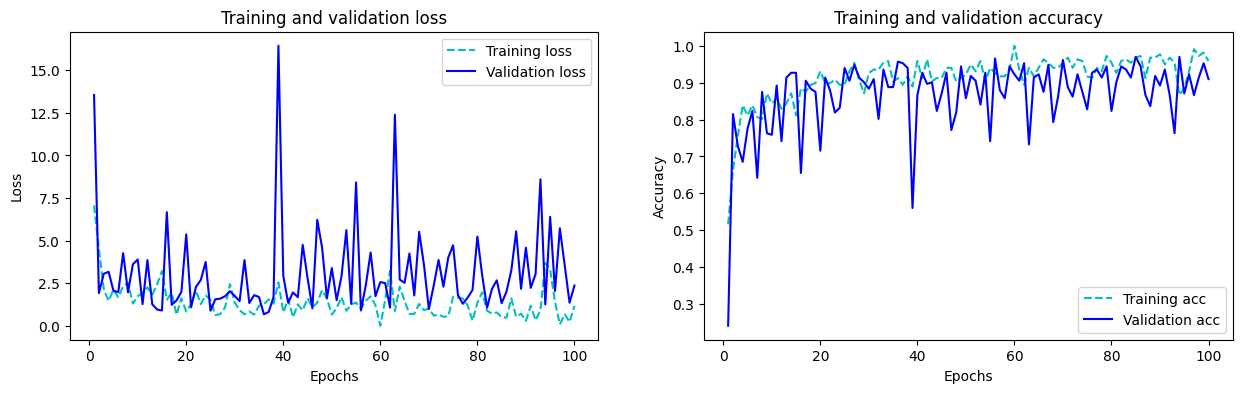

In [46]:
show_result(history_inceptionresnetv2_gray_model)

In [47]:
model_gray_inrnv2 = models.load_model('history_inceptionresnetv2_gray_model.h5')
#all_test_df["label"] = all_test_df["label"].replace({'Cemento' : 0, 'Ossifying' : 1, 'Fibrous' : 2}) 
#evaluation_report(model_gray_inrnv2, test_set_gray, all_test_df['label'])
y_pred_gray_inrnv2 = model_gray_inrnv2.predict(test_set_gray)
y_pred_gray_inrnv2

12/12 [==============================] - 74s 1s/step


array([[4.4569692e-22, 3.3775589e-04, 1.0000000e+00],
       [3.4746699e-21, 1.4135251e-11, 1.0000000e+00],
       [1.5824238e-11, 1.0000000e+00, 3.3220842e-06],
       [3.3873589e-23, 1.0000000e+00, 9.8114669e-01],
       [5.4203658e-10, 1.0000000e+00, 2.5686671e-07],
       [9.7278225e-01, 1.9488538e-20, 1.0000000e+00],
       [3.3793608e-03, 3.2546797e-03, 9.1406006e-01],
       [1.0000000e+00, 2.0773057e-37, 1.0000000e+00],
       [1.1212474e-28, 2.4189760e-12, 1.0000000e+00],
       [4.8348905e-16, 1.0000000e+00, 9.9982363e-01],
       [1.0000000e+00, 1.1718704e-35, 1.7696775e-01],
       [9.9998194e-01, 1.0000000e+00, 4.4292291e-12],
       [1.5347358e-06, 1.0000000e+00, 1.4951001e-11],
       [1.3514843e-10, 3.4126836e-01, 9.9999988e-01],
       [4.6860799e-10, 1.0000000e+00, 1.4591269e-11],
       [9.1726644e-09, 1.0000000e+00, 2.0346697e-10],
       [1.0000000e+00, 2.2772523e-11, 2.8438453e-04],
       [3.6943389e-21, 1.0000000e+00, 9.9952066e-01],
       [8.3519210e-04, 3.007

In [48]:
result = model_gray_inrnv2.evaluate(test_set_gray, verbose=0)

print("Test loss: {:.5f}".format(result[0]))
print("Test accuracy: {:.2f}".format(result[1]))

Test loss: 2.07191
Test accuracy: 0.89


In [49]:
y_pred_gray_inrnv2[:2]

array([[4.4569692e-22, 3.3775589e-04, 1.0000000e+00],
       [3.4746699e-21, 1.4135251e-11, 1.0000000e+00]], dtype=float32)

### Test Predic

In [50]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
# Define predict function
def predict_in(img_path,model):
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.show()

    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)

    pred_class = model.predict(img_preprocessed).argmax(axis =1)

    if pred_class == 1:
      text = 'There is a Cemento'
    elif pred_class == 2:
      text = 'There is a Ossifying'
    else:
      text = 'There is a Fibrous'
    
    
    print('%s %s'%(text,result))

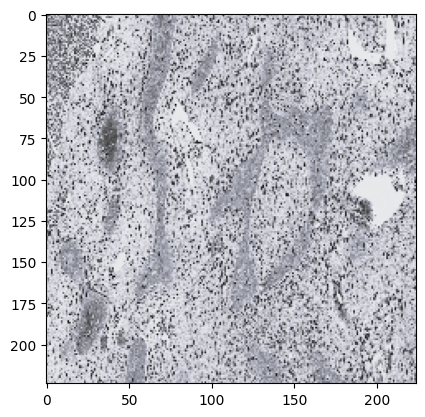

1/1 [==============================] - 52s 52s/step
There is a Ossifying [2.071908473968506, 0.8888888955116272]


In [51]:
predict_in('C:\\Users\\CPE\\Desktop\\senior2023\\fib5.jpg',model_gray_inrnv2 )

### Grad CAM

In [76]:
import tensorflow as tf
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import cv2
import numpy as np
from gradcamutils import *


Path ./Output/gray_inceptionresnet/Cemento_Gradcam/ does not exist. Creating.
Path ./Output/gray_inceptionresnet./Fibrous_Gradcam/ does not exist. Creating.
Path ./Output/gray_inceptionresnet./Ossifying_Gradcam/ does not exist. Creating.
Now save Cemento_Gradcam no.0
Now save Cemento_Gradcam no.1
Now save Cemento_Gradcam no.2
Now save Cemento_Gradcam no.3
Now save Cemento_Gradcam no.4
Now save Cemento_Gradcam no.5
Now save Cemento_Gradcam no.6
Now save Cemento_Gradcam no.7
Now save Cemento_Gradcam no.8
Now save Cemento_Gradcam no.9
Now save Cemento_Gradcam no.10
Now save Cemento_Gradcam no.11
Now save Cemento_Gradcam no.12
Now save Cemento_Gradcam no.13
Now save Cemento_Gradcam no.14
Now save Fibrous_Gradcam no.0
Now save Fibrous_Gradcam no.1
Now save Fibrous_Gradcam no.2
Now save Fibrous_Gradcam no.3
Now save Fibrous_Gradcam no.4
Now save Fibrous_Gradcam no.5
Now save Fibrous_Gradcam no.6
Now save Fibrous_Gradcam no.7
Now save Fibrous_Gradcam no.8
Now save Fibrous_Gradcam no.9
Now sav

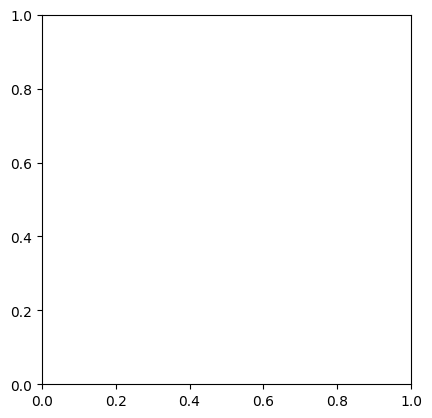

In [88]:
TYPE = "gray_inceptionresnet"
PATH = os.path.join('C:\\Users\\CPE\\Desktop\\senior2023\\gray')
# output_dir = './Output/split_'+TYPE
# test_dir = os.path.join(PATH, 'split_test')
output_dir = './Output/'+TYPE
test_dir = os.path.join(PATH, 'test_cell') #, 'test_cell'
test_cem_dir = os.path.join(test_dir, 'ce')
test_fib_dir = os.path.join(test_dir, 'fi')
test_oss_dir = os.path.join(test_dir, 'os')

BATCH_SIZE = 4
IMG_HEIGHT = 224
IMG_WIDTH = 224

output_cem = output_dir+"/Cemento_Gradcam/"
output_fib = output_dir+"./Fibrous_Gradcam/"
output_oss = output_dir+"./Ossifying_Gradcam/"

if not os.path.isdir(output_cem):
    print("Path {} does not exist. Creating.".format(output_cem))
    os.makedirs(output_cem)
else:
    print("Path {} exists. Remove and remake.".format(output_cem))
    shutil.rmtree(output_cem)
    os.makedirs(output_cem)

if not os.path.isdir(output_fib):
    print("Path {} does not exist. Creating.".format(output_fib))
    os.makedirs(output_fib)
else:
    print("Path {} exists. Remove and remake.".format(output_fib))
    shutil.rmtree(output_fib)
    os.makedirs(output_fib)

if not os.path.isdir(output_oss):
    print("Path {} does not exist. Creating.".format(output_oss))
    os.makedirs(output_oss)
else:
    print("Path {} exists. Remove and remake.".format(output_oss))
    shutil.rmtree(output_oss)
    os.makedirs(output_oss)

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

model = load_model('history_inceptionresnetv2_gray_model.h5')
layer_name = model.layers[-4].name

for i, name in enumerate(os.listdir(test_cem_dir)):
    img_path = test_cem_dir+"/"+name
    orig_img = np.array(load_img(img_path),dtype=np.uint8)
    img_array = np.array(load_img(img_path, target_size=(IMG_HEIGHT,IMG_WIDTH)))
    img_array = img_to_array(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    faster_score_cam=ScoreCam(model,img_array,layer_name, max_N=10)
    faster_score_cam_superimposed = superimpose(img_path, faster_score_cam)
    faster_score_cam_emphasized = superimpose(img_path, faster_score_cam, emphasize=True)
    plt.imshow(faster_score_cam_emphasized)
    # plt.show()
    plt.savefig(output_cem+name)
    plt.cla()
    print('Now save Cemento_Gradcam no.'+str(i))

for i, name in enumerate(os.listdir(test_fib_dir)):
    img_path = test_fib_dir+"/"+name
    orig_img = np.array(load_img(img_path),dtype=np.uint8)
    img_array = np.array(load_img(img_path, target_size=(IMG_HEIGHT,IMG_WIDTH)))
    img_array = img_to_array(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    faster_score_cam=ScoreCam(model,img_array,layer_name, max_N=10)
    faster_score_cam_superimposed = superimpose(img_path, faster_score_cam)
    faster_score_cam_emphasized = superimpose(img_path, faster_score_cam, emphasize=True)
    plt.imshow(faster_score_cam_emphasized)
    # plt.show()
    plt.savefig(output_fib+name)
    plt.cla()
    print('Now save Fibrous_Gradcam no.'+str(i))

for i, name in enumerate(os.listdir(test_oss_dir)):
    img_path = test_oss_dir+"/"+name
    orig_img = np.array(load_img(img_path),dtype=np.uint8)
    img_array = np.array(load_img(img_path, target_size=(IMG_HEIGHT,IMG_WIDTH)))
    img_array = img_to_array(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    faster_score_cam=ScoreCam(model,img_array,layer_name, max_N=10)
    faster_score_cam_superimposed = superimpose(img_path, faster_score_cam)
    faster_score_cam_emphasized = superimpose(img_path, faster_score_cam, emphasize=True)
    plt.imshow(faster_score_cam_emphasized)
    # plt.show()
    plt.savefig(output_oss+name)
    plt.cla()
    print('Now save Ossifying_Gradcam no.'+str(i))


### Model Xception

#Summary of Xception Model
model_xcep1.summary()

In [85]:
xcep_1 = xcep1_model
xcep_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [57]:
#early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5) 
mcp_save = ModelCheckpoint('history_Xception_gray_model.h5', save_best_only=True, monitor='val_loss')

history_Xception_gray_model = xcep_1.fit(
                      training_set_gray,
                      batch_size=4,
                      epochs=100,
                      validation_data = (validation_set_gray),
                      callbacks=[mcp_save]
                      )

Epoch 1/100
55/55 [==============================] - 223s 3s/step - loss: 1.0510 - acc: 0.5668 - val_loss: 0.6910 - val_acc: 0.7241
Epoch 2/100
55/55 [==============================] - 153s 3s/step - loss: 0.6252 - acc: 0.7512 - val_loss: 0.5594 - val_acc: 0.8017
Epoch 3/100
55/55 [==============================] - 144s 3s/step - loss: 0.5132 - acc: 0.7972 - val_loss: 0.3972 - val_acc: 0.8750
Epoch 4/100
55/55 [==============================] - 150s 3s/step - loss: 0.4129 - acc: 0.8249 - val_loss: 0.3647 - val_acc: 0.8491
Epoch 5/100
55/55 [==============================] - 144s 3s/step - loss: 0.3912 - acc: 0.8525 - val_loss: 0.4057 - val_acc: 0.8621
Epoch 6/100
55/55 [==============================] - 149s 3s/step - loss: 0.3600 - acc: 0.8571 - val_loss: 0.4661 - val_acc: 0.8103
Epoch 7/100
55/55 [==============================] - 147s 3s/step - loss: 0.3193 - acc: 0.8802 - val_loss: 0.3290 - val_acc: 0.8707
Epoch 8/100
55/55 [==============================] - 140s 3s/step - loss: 0.

Highest validation accuracy in Epoch: 92
Train accuracy: 0.9447004795074463
Validation accuracy: 0.9568965435028076
--------------------------------------------------
Last train Epoch
Train accuracy: 0.9308755993843079
Validation accuracy: 0.7887930870056152


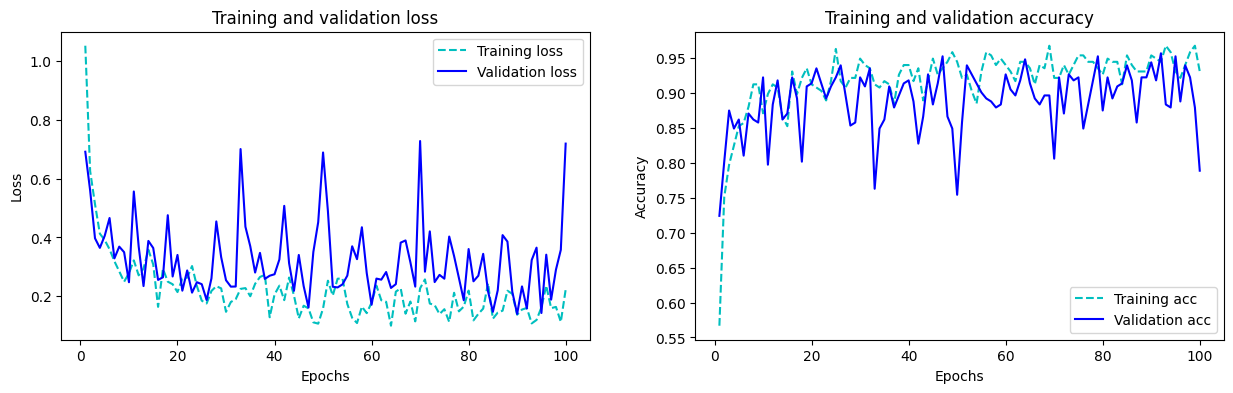

In [58]:
show_result(history_Xception_gray_model)

In [59]:
xcep_gray_model = models.load_model('history_Xception_gray_model.h5')
#all_test_df["label"] = all_test_df["label"].replace({'Cemento' : 0, 'Ossifying' : 1, 'Fibrous' : 2}) 
#evaluation_report(xcep_gray, test_set_gray, all_test_df['label'])

In [60]:
result2 = xcep_gray_model.evaluate(test_set_gray, verbose=0)

print("Test loss: {:.5f}".format(result2[0]))
print("Test accuracy: {:.2f}".format(result2[1]))

Test loss: 0.60525
Test accuracy: 0.84


### Test Predic

In [61]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
# Define predict function
def predict_xc(img_path,model):
    img = image.load_img(img_path, target_size=(299, 299))
    plt.imshow(img)
    plt.show()

    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)

    pred_class = model.predict(img_preprocessed).argmax(axis =1)

    if pred_class == 1:
      text = 'There is a Cemento'
    elif pred_class == 2:
      text = 'There is a Ossifying'
    else:
      text = 'There is a Fibrous'
    
    
    print('%s %s'%(text,result2))

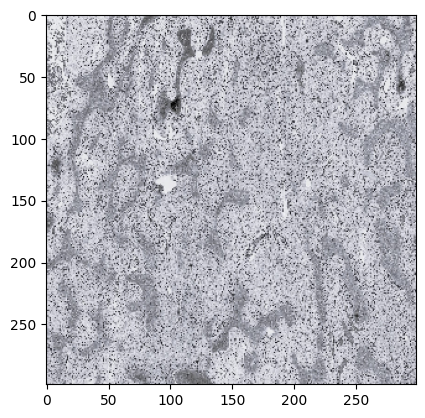

1/1 [==============================] - 2s 2s/step
There is a Cemento [0.6052539944648743, 0.8444444537162781]


In [62]:
predict_xc('C:\\Users\\CPE\\Desktop\\senior2023\\fib1.jpg',xcep_gray_model)

### Grad cam

Path ./Output/gray_xception/Cemento_Gradcam/ does not exist. Creating.
Path ./Output/gray_xception./Fibrous_Gradcam/ does not exist. Creating.
Path ./Output/gray_xception./Ossifying_Gradcam/ does not exist. Creating.
Now save Cemento_Gradcam no.0
Now save Cemento_Gradcam no.1
Now save Cemento_Gradcam no.2
Now save Cemento_Gradcam no.3
Now save Cemento_Gradcam no.4
Now save Cemento_Gradcam no.5
Now save Cemento_Gradcam no.6
Now save Cemento_Gradcam no.7
Now save Cemento_Gradcam no.8
Now save Cemento_Gradcam no.9
Now save Cemento_Gradcam no.10
Now save Cemento_Gradcam no.11
Now save Cemento_Gradcam no.12
Now save Cemento_Gradcam no.13
Now save Cemento_Gradcam no.14
Now save Fibrous_Gradcam no.0
Now save Fibrous_Gradcam no.1
Now save Fibrous_Gradcam no.2
Now save Fibrous_Gradcam no.3
Now save Fibrous_Gradcam no.4
Now save Fibrous_Gradcam no.5
Now save Fibrous_Gradcam no.6
Now save Fibrous_Gradcam no.7


c:\Users\CPE\Desktop\senior2023\gradcamutils.py:109: RuntimeWarning: invalid value encountered in true_divide
  cam /= np.max(cam)  # scale 0 to 1.0


Now save Fibrous_Gradcam no.8
Now save Fibrous_Gradcam no.9
Now save Fibrous_Gradcam no.10
Now save Fibrous_Gradcam no.11
Now save Fibrous_Gradcam no.12
Now save Fibrous_Gradcam no.13
Now save Fibrous_Gradcam no.14
Now save Ossifying_Gradcam no.0
Now save Ossifying_Gradcam no.1
Now save Ossifying_Gradcam no.2
Now save Ossifying_Gradcam no.3
Now save Ossifying_Gradcam no.4
Now save Ossifying_Gradcam no.5
Now save Ossifying_Gradcam no.6
Now save Ossifying_Gradcam no.7
Now save Ossifying_Gradcam no.8
Now save Ossifying_Gradcam no.9
Now save Ossifying_Gradcam no.10
Now save Ossifying_Gradcam no.11
Now save Ossifying_Gradcam no.12
Now save Ossifying_Gradcam no.13
Now save Ossifying_Gradcam no.14


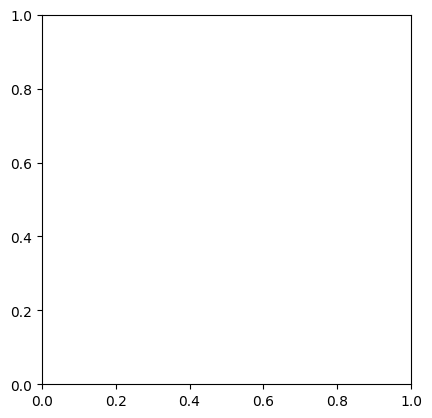

In [89]:
TYPE = "gray_xception"
PATH = os.path.join('C:\\Users\\CPE\\Desktop\\senior2023\\gray')
# output_dir = './Output/split_'+TYPE
# test_dir = os.path.join(PATH, 'split_test')
output_dir = './Output/'+TYPE
test_dir = os.path.join(PATH, 'test_cell') #, 'test_cell'
test_cem_dir = os.path.join(test_dir, 'ce')
test_fib_dir = os.path.join(test_dir, 'fi')
test_oss_dir = os.path.join(test_dir, 'os')

BATCH_SIZE = 4
IMG_HEIGHT = 299
IMG_WIDTH = 299

output_cem = output_dir+"/Cemento_Gradcam/"
output_fib = output_dir+"./Fibrous_Gradcam/"
output_oss = output_dir+"./Ossifying_Gradcam/"

if not os.path.isdir(output_cem):
    print("Path {} does not exist. Creating.".format(output_cem))
    os.makedirs(output_cem)
else:
    print("Path {} exists. Remove and remake.".format(output_cem))
    shutil.rmtree(output_cem)
    os.makedirs(output_cem)

if not os.path.isdir(output_fib):
    print("Path {} does not exist. Creating.".format(output_fib))
    os.makedirs(output_fib)
else:
    print("Path {} exists. Remove and remake.".format(output_fib))
    shutil.rmtree(output_fib)
    os.makedirs(output_fib)

if not os.path.isdir(output_oss):
    print("Path {} does not exist. Creating.".format(output_oss))
    os.makedirs(output_oss)
else:
    print("Path {} exists. Remove and remake.".format(output_oss))
    shutil.rmtree(output_oss)
    os.makedirs(output_oss)

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

model = load_model('history_Xception_gray_model.h5')
layer_name = model.layers[-13].name

for i, name in enumerate(os.listdir(test_cem_dir)):
    img_path = test_cem_dir+"/"+name
    orig_img = np.array(load_img(img_path),dtype=np.uint8)
    img_array = np.array(load_img(img_path, target_size=(IMG_HEIGHT,IMG_WIDTH)))
    img_array = img_to_array(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    faster_score_cam=ScoreCam(model,img_array,layer_name, max_N=10)
    faster_score_cam_superimposed = superimpose(img_path, faster_score_cam)
    faster_score_cam_emphasized = superimpose(img_path, faster_score_cam, emphasize=True)
    plt.imshow(faster_score_cam_emphasized)
    # plt.show()
    plt.savefig(output_cem+name)
    plt.cla()
    print('Now save Cemento_Gradcam no.'+str(i))

for i, name in enumerate(os.listdir(test_fib_dir)):
    img_path = test_fib_dir+"/"+name
    orig_img = np.array(load_img(img_path),dtype=np.uint8)
    img_array = np.array(load_img(img_path, target_size=(IMG_HEIGHT,IMG_WIDTH)))
    img_array = img_to_array(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    faster_score_cam=ScoreCam(model,img_array,layer_name, max_N=10)
    faster_score_cam_superimposed = superimpose(img_path, faster_score_cam)
    faster_score_cam_emphasized = superimpose(img_path, faster_score_cam, emphasize=True)
    plt.imshow(faster_score_cam_emphasized)
    # plt.show()
    plt.savefig(output_fib+name)
    plt.cla()
    print('Now save Fibrous_Gradcam no.'+str(i))

for i, name in enumerate(os.listdir(test_oss_dir)):
    img_path = test_oss_dir+"/"+name
    orig_img = np.array(load_img(img_path),dtype=np.uint8)
    img_array = np.array(load_img(img_path, target_size=(IMG_HEIGHT,IMG_WIDTH)))
    img_array = img_to_array(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    faster_score_cam=ScoreCam(model,img_array,layer_name, max_N=10)
    faster_score_cam_superimposed = superimpose(img_path, faster_score_cam)
    faster_score_cam_emphasized = superimpose(img_path, faster_score_cam, emphasize=True)
    plt.imshow(faster_score_cam_emphasized)
    # plt.show()
    plt.savefig(output_oss+name)
    plt.cla()
    print('Now save Ossifying_Gradcam no.'+str(i))

### Model gray EfficientnetB2

effi1_model.summary()

In [63]:
effi_1 = effi1_model

In [64]:
#early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=2) 
#mcp_save = ModelCheckpoint('history_efficientnet1_1_model.h5', save_best_only=True, monitor='val_loss')

history_efficientnet_gray_model = effi_1.fit(
                      training_set_gray,
                      batch_size=4,
                      epochs=100,
                      validation_data = (validation_set_gray)
                      #callbacks=[mcp_save]
                      )
#effi_1.save('history_efficientnet_gray_model.h5')

Epoch 1/100
55/55 [==============================] - 84s 1s/step - loss: 1.0988 - acc: 0.3502 - val_loss: 1.0924 - val_acc: 0.7716
Epoch 2/100
55/55 [==============================] - 54s 995ms/step - loss: 1.0985 - acc: 0.3502 - val_loss: 1.0855 - val_acc: 0.7716
Epoch 3/100
55/55 [==============================] - 54s 988ms/step - loss: 1.0986 - acc: 0.3502 - val_loss: 1.0778 - val_acc: 0.7716
Epoch 4/100
55/55 [==============================] - 53s 958ms/step - loss: 1.0983 - acc: 0.3502 - val_loss: 1.0785 - val_acc: 0.7716
Epoch 5/100
55/55 [==============================] - 54s 985ms/step - loss: 1.0985 - acc: 0.3502 - val_loss: 1.0727 - val_acc: 0.7716
Epoch 6/100
55/55 [==============================] - 53s 968ms/step - loss: 1.0985 - acc: 0.3502 - val_loss: 1.0708 - val_acc: 0.7716
Epoch 7/100
55/55 [==============================] - 53s 971ms/step - loss: 1.0982 - acc: 0.3502 - val_loss: 1.0684 - val_acc: 0.7716
Epoch 8/100
55/55 [==============================] - 54s 982ms/st

Highest validation accuracy in Epoch: 1
Train accuracy: 0.3502304255962372
Validation accuracy: 0.7715517282485962
--------------------------------------------------
Last train Epoch
Train accuracy: 0.3963133692741394
Validation accuracy: 0.7715517282485962


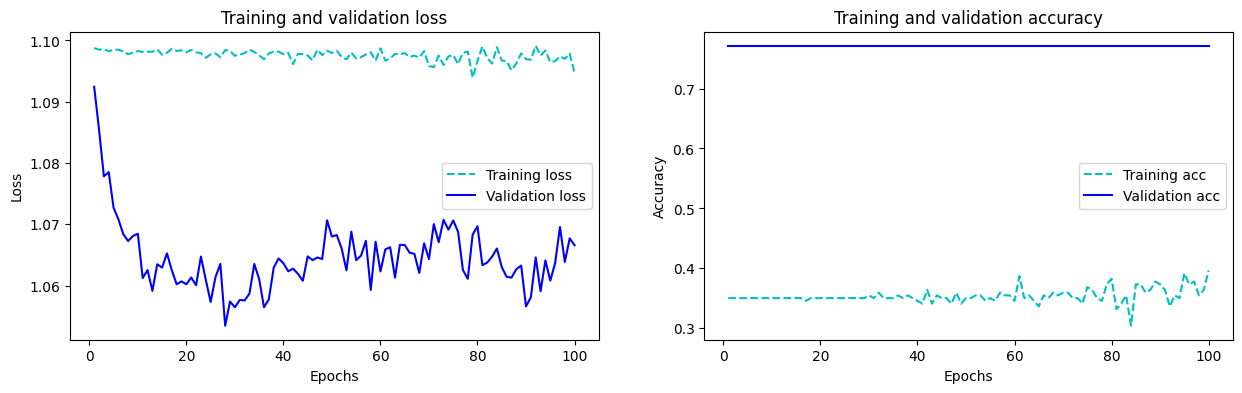

In [65]:
show_result(history_efficientnet_gray_model)

In [66]:
#mcp_save = ModelCheckpoint('history_efficientnet_gray_model.h5', save_best_only=True, monitor='val_loss')

In [67]:
#effi = models.load_model('history_efficientnet1_1_model.h5')
#all_test_df["label"] = all_test_df["label"].replace({'Cemento' : 0, 'Ossifying' : 1, 'Fibrous' : 2}) 
#evaluation_report(history_efficientnet1_1_model , test_set_gray, all_test_df['label'])

In [68]:
#result3 = effi1_model.evaluate(test_set_gray, verbose=0)

#print("Test loss: {:.5f}".format(result3[0]))
#print("Test accuracy: {:.2f}".format(result3[1]))

### Test predic

In [69]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
# Define predict function
def predict_ef(img_path,model):
    img = image.load_img(img_path, target_size=(260, 260))
    plt.imshow(img)
    plt.show()

    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)

    pred_class = model.predict(img_preprocessed).argmax(axis =1)

    if pred_class == 1:
      text = 'There is a Cemento'
    elif pred_class == 2:
      text = 'There is a Ossifying'
    else:
      text = 'There is a Fibrous'
    
    
    print('%s %s'%(text,result))

In [70]:
#predict_ef('C:\\Users\\CPE\\Desktop\\senior2023\\ossifying_fibroma.jpg',effi)